# Analise dos dados de diferenciacao em fotoesfera

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import cluster, datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster

In [2]:
# Carregar os dados
data = pd.read_excel('area e intensidade.xlsx', sheet_name='Sheet2')

print(data)

         Grupo      ID    Area    Mean    StdDev  Mode  Min   Max      X  \
0       1%_FBS   rodo1  14240.0  21964  8834.000    27     5   85  11251   
1       1%_FBS   rodo2   3358.0   8353  3159.000     8     4   32   4815   
2       1%_FBS   rodo3   4018.0   5022  1170.000     6     4   34   2724   
3       1%_FBS   rodo4   7209.0  10124  3080.000    11     5   56   5419   
4       1%_FBS   rodo5  21694.0  16520  6080.000    17     2   83   9646   
..         ...     ...      ...    ...       ...   ...   ...  ...    ...   
106  neuro_ctl  rodo16   2734.0   8217  2445.000     7     4   44  16399   
107  neuro_ctl  rodo17   1972.0   3084     0.931     4     2   12  17894   
108  neuro_ctl  rodo18   1891.0   9769  3296.000    11     4   37  16657   
109  neuro_ctl  rodo19   6271.0   8679  4125.000     8     1   85   8836   
110  neuro_ctl  rodo20  10530.0   2271     0.640     3     1   27  10689   

         Y  ...  %Area  RawIntDen  Slice  FeretX  FereY  FeretAngle  MinFeret  \
0     

In [3]:
# Selecionar as características relevantes
X = data[['Mean','Area ','StdDev','Median','Mode','IntDen','Perim.']]
# 'X','Y','XM','YM','BX','BY','Width','Height','Major','Minor','Angle','Skew','Feret','FeretX','FereY','FeretAngle',
# 'MinFeret','AR','Circ.','Min ','Max','Kurt','Round','Solidity''RawIntDen'

Area - Area of selection in square pixels. 

Mean Gray Value - Average gray value within the selection. This is the sum of the gray values of all the pixels in the selection divided by the number of pixels.

Standard Deviation - Standard deviation of the gray values used to generate the mean gray value. 

Modal Gray Value - Most frequently occurring gray value within the selection. Corresponds to the highest peak in the histogram.

Perimeter - The length of the outside boundary of the selection. 

Integrated Density - Calculates and displays two values: "IntDen" (the product of Area and Mean Gray Value) and 

Median - The median value of the pixels in the image or selection. 

# 1º Avaliar a variancia dos features e correlaçao entre eles

In [4]:
# Calcular a variância das colunas

variance = X.var()

# Exibir as variâncias ordenadas
variance_sorted = variance.sort_values(ascending=False)
print(variance_sorted)

IntDen    1.411835e+10
Mean      1.700289e+08
Area      4.808044e+07
StdDev    3.028550e+07
Perim.    1.817678e+07
Mode      3.294670e+02
Median    1.712577e+02
dtype: float64


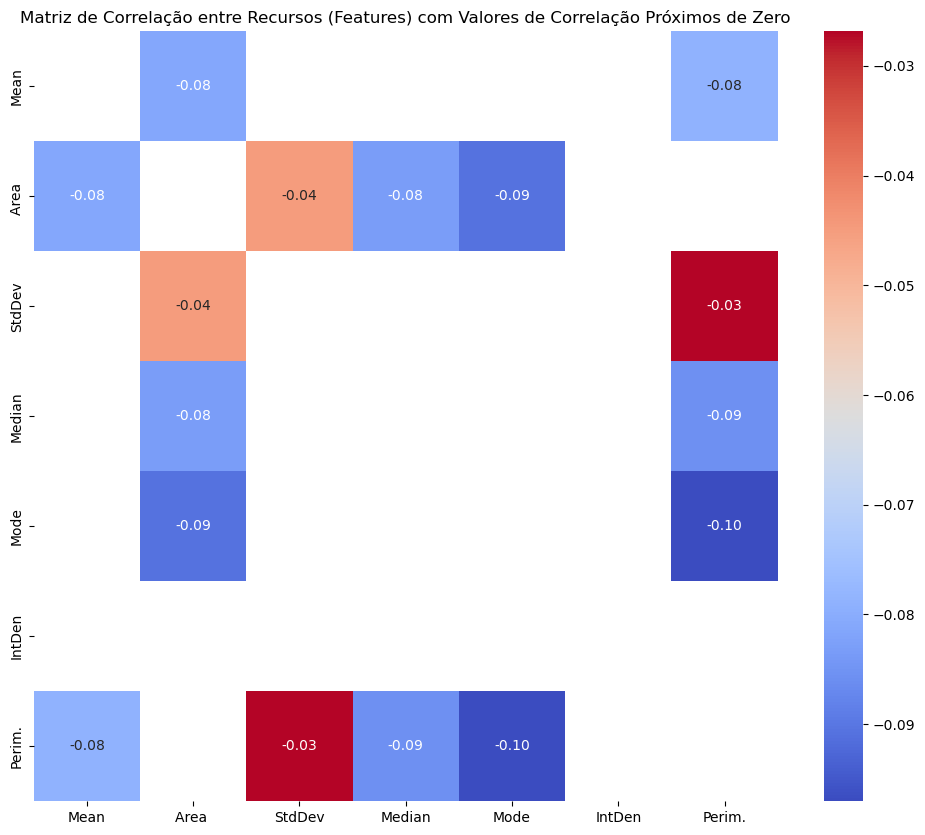

In [5]:
# Calcular a matriz de correlação
correlation_matrix = X.corr()

# Filtrar os valores de correlação próximos de zero
filtered_correlation_matrix = correlation_matrix[abs(correlation_matrix) < 0.1]

# Plotar o mapa de calor da matriz de correlação filtrada
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre Recursos (Features) com Valores de Correlação Próximos de Zero')
plt.show()

In [6]:
# Obter os pares de características com correlação próxima de zero
pairs = filtered_correlation_matrix.stack().index.tolist()

## Imprimir os pares de características com correlação próxima de zero
print("Pares de características com correlação próxima de zero:")
for pair in pairs:
    print(pair)

Pares de características com correlação próxima de zero:
('Mean', 'Area ')
('Mean', 'Perim.')
('Area ', 'Mean')
('Area ', 'StdDev')
('Area ', 'Median')
('Area ', 'Mode')
('StdDev', 'Area ')
('StdDev', 'Perim.')
('Median', 'Area ')
('Median', 'Perim.')
('Mode', 'Area ')
('Mode', 'Perim.')
('Perim.', 'Mean')
('Perim.', 'StdDev')
('Perim.', 'Median')
('Perim.', 'Mode')


Com isso, Mean e Area tem maior variancia e correlaçao proxima ao nulo, assim o par a ser usado a seguir.
(IntDen tem maior variancia, mas nao tem correlacao proximo ao nulo com outros valores)

# 1° Cluster hierarquico

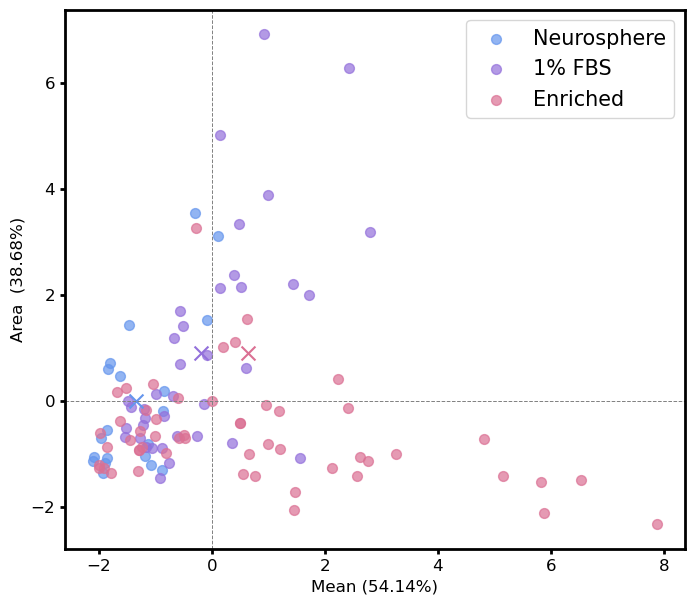

In [8]:
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
    
# Aplicar o PCA
pca = PCA(0.95)
X_pca = pca.fit_transform(X_normalized)

# Aplicar o agrupamento hierárquico
Z = linkage(X_pca, method='ward')

# Definir o número de clusters desejados
num_clusters = 3

# Realizar o clustering hierárquico e obter os rótulos dos clusters
labels = fcluster(Z, num_clusters)

# Separar os grupos
neuro_indices = data[data['Grupo'] == 'neuro_ctl'].index
FBS_indices = data[data['Grupo'] == '1%_FBS'].index
enric_indices = data[data['Grupo'] == 'enriched'].index

# Calcular os centroides de cada grupo
centroid_control = np.mean(X_pca[neuro_indices], axis=0)
centroid_FBS = np.mean(X_pca[FBS_indices], axis=0)
centroid_enric = np.mean(X_pca[enric_indices], axis=0)

# Plotar
plt.figure(figsize=(8, 7))

plt.scatter(X_pca[neuro_indices, 0], X_pca[neuro_indices, 1], label='Neurosphere', color='cornflowerblue',alpha=0.7, s=50)
plt.scatter(X_pca[FBS_indices, 0], X_pca[FBS_indices, 1], label='1% FBS', color='mediumpurple',alpha=0.7, s=50)
plt.scatter(X_pca[enric_indices, 0], X_pca[enric_indices, 1], label='Enriched', color='palevioletred',alpha=0.7, s=50)

plt.scatter(centroid_control[0], centroid_control[1], marker='x', color='cornflowerblue',s=100)
plt.scatter(centroid_FBS[0], centroid_FBS[1], marker='x', color='mediumpurple',s=100)
plt.scatter(centroid_enric[0], centroid_FBS[1], marker='x', color='palevioletred',s=100)

# Adicionar linhas de referência para os eixos
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)

# Adicionar nomes das características e variáveis nos eixos
plt.gca().tick_params(axis='x', labelsize=12, width=2)  
plt.gca().tick_params(axis='y', labelsize=12, width=2)
plt.xlabel(f"{X.columns[0]} ({pca.explained_variance_ratio_[0] * 100:.2f}%)", fontsize=12)
plt.ylabel(f"{X.columns[1]} ({pca.explained_variance_ratio_[1] * 100:.2f}%)", fontsize=12)

# Ajustar a espessura das linhas dos eixos x e y
plt.gca().spines[['bottom','left','top', 'right']].set_linewidth(2)

#plt.title('Hierarchical Clustering', fontsize=12, weight='bold')
plt.legend(fontsize=15)

# Salvar a figura
#plt.savefig('Clustering Hierárquico fotoesfera.tiff', dpi=600)

plt.show()

## Adiçao de centroides e elipses ao redor dos centroides  (versao usada)

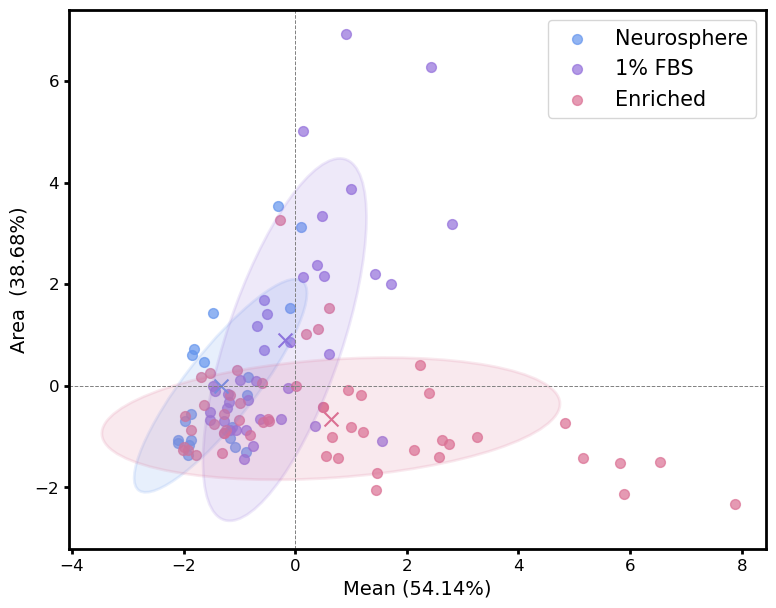

In [9]:
from sklearn.covariance import EmpiricalCovariance
from matplotlib.patches import Ellipse

# Calcular a matriz de covariância para cada grupo
cov_control = EmpiricalCovariance().fit(X_pca[neuro_indices])
cov_FBS = EmpiricalCovariance().fit(X_pca[FBS_indices])
cov_enric = EmpiricalCovariance().fit(X_pca[enric_indices])

# Calcular os autovalores e autovetores da matriz de covariância para cada grupo
autovalores_control, autovetores_control = np.linalg.eigh(cov_control.covariance_)
autovalores_FBS, autovetores_FBS = np.linalg.eigh(cov_FBS.covariance_)
autovalores_enric, autovetores_enric = np.linalg.eigh(cov_enric.covariance_)

# Plotar
plt.figure(figsize=(9, 7))

plt.scatter(X_pca[neuro_indices, 0], X_pca[neuro_indices, 1], label='Neurosphere', color='cornflowerblue', alpha=0.7, s=50)
plt.scatter(X_pca[FBS_indices, 0], X_pca[FBS_indices, 1], label='1% FBS', color='mediumpurple', alpha=0.7, s=50)
plt.scatter(X_pca[enric_indices, 0], X_pca[enric_indices, 1], label='Enriched', color='palevioletred', alpha=0.7, s=50)

plt.scatter(centroid_control[0], centroid_control[1], marker='x', color='cornflowerblue', s=100)
plt.scatter(centroid_FBS[0], centroid_FBS[1], marker='x', color='mediumpurple', s=100)
plt.scatter(centroid_enric[0], centroid_enric[1], marker='x', color='palevioletred', s=100)

# Adicionar elipses representando o desvio padrão dos pontos em torno dos centroides
for i, (autovalores, autovetores, centroide, cor) in enumerate(zip([autovalores_control, autovalores_FBS, autovalores_enric],
                                                                    [autovetores_control, autovetores_FBS, autovetores_enric],
                                                                    [centroid_control, centroid_FBS, centroid_enric],
                                                                    ['cornflowerblue', 'mediumpurple', 'palevioletred'])):
    angulo = np.degrees(np.arctan2(autovetores[1, 0], autovetores[0, 0]))
    raizes_autovalores = np.sqrt(autovalores)
    largura, altura = 2 * raizes_autovalores[-2:]*1.3
    fator_aumento = 1.3
    altura *= fator_aumento
    elipse = Ellipse(xy=centroide, width=largura, height=altura, angle=angulo, edgecolor=cor,fc=cor, alpha=0.15, lw=2)
    plt.gca().add_patch(elipse)

# Adicionar linhas de referência para os eixos
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)

# Adicionar nomes das características e variáveis nos eixos
plt.gca().tick_params(axis='x', labelsize=12, width=2, grid_color= 'black')  
plt.gca().tick_params(axis='y', labelsize=12, width=2)
plt.xlabel(f"{X.columns[0]} ({pca.explained_variance_ratio_[0] * 100:.2f}%)", fontsize=14)
plt.ylabel(f"{X.columns[1]} ({pca.explained_variance_ratio_[1] * 100:.2f}%)", fontsize=14)

# Ajustar a espessura das linhas dos eixos x e y
plt.gca().spines[['bottom','left','top', 'right']].set_linewidth(2)

plt.legend(fontsize=15)

# Salvar a figura
#plt.savefig('Clustering Hierárquico fotoesfera.tiff', dpi=600)

plt.show()

### Calculo da distância euclidiana entre os centroides e desvio padrão dos pontos¶

In [10]:
# Calcula a distância euclidiana entre os centroides
distancia1 = np.linalg.norm(centroid_control - centroid_enric)
distancia2 = np.linalg.norm(centroid_FBS - centroid_enric)

print("Distância entre os centroides Neurosphere vs. Enriched:", distancia1)
print("Distância entre os centroides FBS vs. Enriched:", distancia2)

# Calcula o desvio padrão das coordenadas dos pontos em torno dos centroides
desvio_padrao_control = np.std(centroid_control, axis=0)
desvio_padrao_FBS = np.std(centroid_FBS, axis=0)
desvio_padrao_enric = np.std(centroid_enric, axis=0)

print("Desvio padrão do cluster Neurosphere:", desvio_padrao_control)
print("Desvio padrão do cluster FBS:", desvio_padrao_FBS)
print("Desvio padrão do cluster Enriched:", desvio_padrao_enric)

Distância entre os centroides Neurosphere vs. Enriched: 2.112700080848705
Distância entre os centroides FBS vs. Enriched: 1.776859000424012
Desvio padrão do cluster Neurosphere: 0.5858279517943182
Desvio padrão do cluster FBS: 0.49274277259838806
Desvio padrão do cluster Enriched: 0.5309908852335704


## Adiçao de centroides e elipses ao redor dos centroides

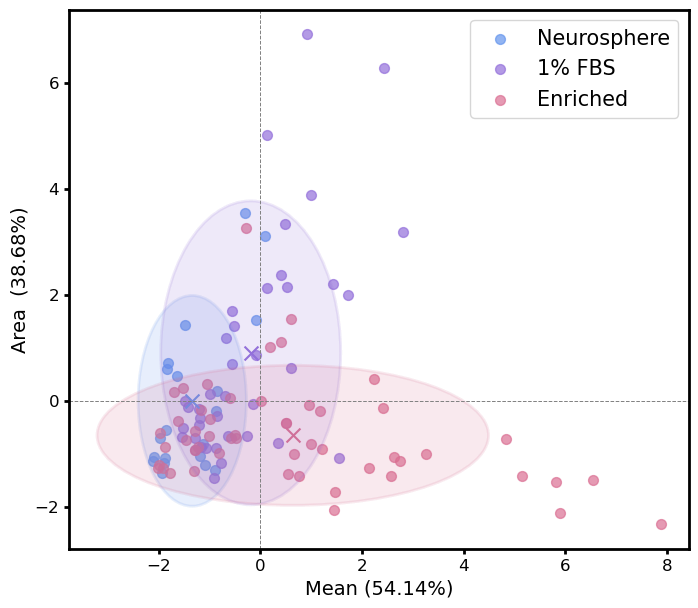

In [11]:
from matplotlib.patches import Ellipse

# Calcular os desvios padrão em torno de cada ponto médio
std_neuro = np.std(X_pca[neuro_indices], axis=0)
std_FBS = np.std(X_pca[FBS_indices], axis=0)
std_enric = np.std(X_pca[enric_indices], axis=0)

# Plotar
plt.figure(figsize=(8, 7))

plt.scatter(X_pca[neuro_indices, 0], X_pca[neuro_indices, 1], label='Neurosphere', color='cornflowerblue', alpha=0.7, s=50)
plt.scatter(X_pca[FBS_indices, 0], X_pca[FBS_indices, 1], label='1% FBS', color='mediumpurple', alpha=0.7, s=50)
plt.scatter(X_pca[enric_indices, 0], X_pca[enric_indices, 1], label='Enriched', color='palevioletred', alpha=0.7, s=50)

plt.scatter(centroid_control[0], centroid_control[1], marker='x', color='cornflowerblue', s=100)
plt.scatter(centroid_FBS[0], centroid_FBS[1], marker='x', color='mediumpurple', s=100)
plt.scatter(centroid_enric[0], centroid_enric[1], marker='x', color='palevioletred', s=100)

# Adicionar elipses representando o desvio padrão dos pontos em torno de cada ponto médio
for centroide, std, cor in zip([centroid_control, centroid_FBS, centroid_enric],
                                [std_neuro, std_FBS, std_enric],
                                ['cornflowerblue', 'mediumpurple', 'palevioletred']):
    for i in range(len(centroide)):
        largura = 2 * std[0] * 1.6
        altura = 2 * std[1] * 1.4
        angulo = 0
        elipse = Ellipse(xy=centroide, width=largura, height=altura, angle=angulo, fc=cor, alpha=0.05, edgecolor=cor, lw=2)
        plt.gca().add_patch(elipse)

# Adicionar linhas de referência para os eixos
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)

# Adicionar nomes das características e variáveis nos eixos
plt.gca().tick_params(axis='x', labelsize=12, width=2, grid_color= 'black')  
plt.gca().tick_params(axis='y', labelsize=12, width=2)
plt.xlabel(f"{X.columns[0]} ({pca.explained_variance_ratio_[0] * 100:.2f}%)", fontsize=14)
plt.ylabel(f"{X.columns[1]} ({pca.explained_variance_ratio_[1] * 100:.2f}%)", fontsize=14)

# Ajustar a espessura das linhas dos eixos x e y
plt.gca().spines[['bottom','left','top', 'right']].set_linewidth(2)

plt.legend(fontsize=15)
plt.show()


# Forma de plotar varios clusteres 

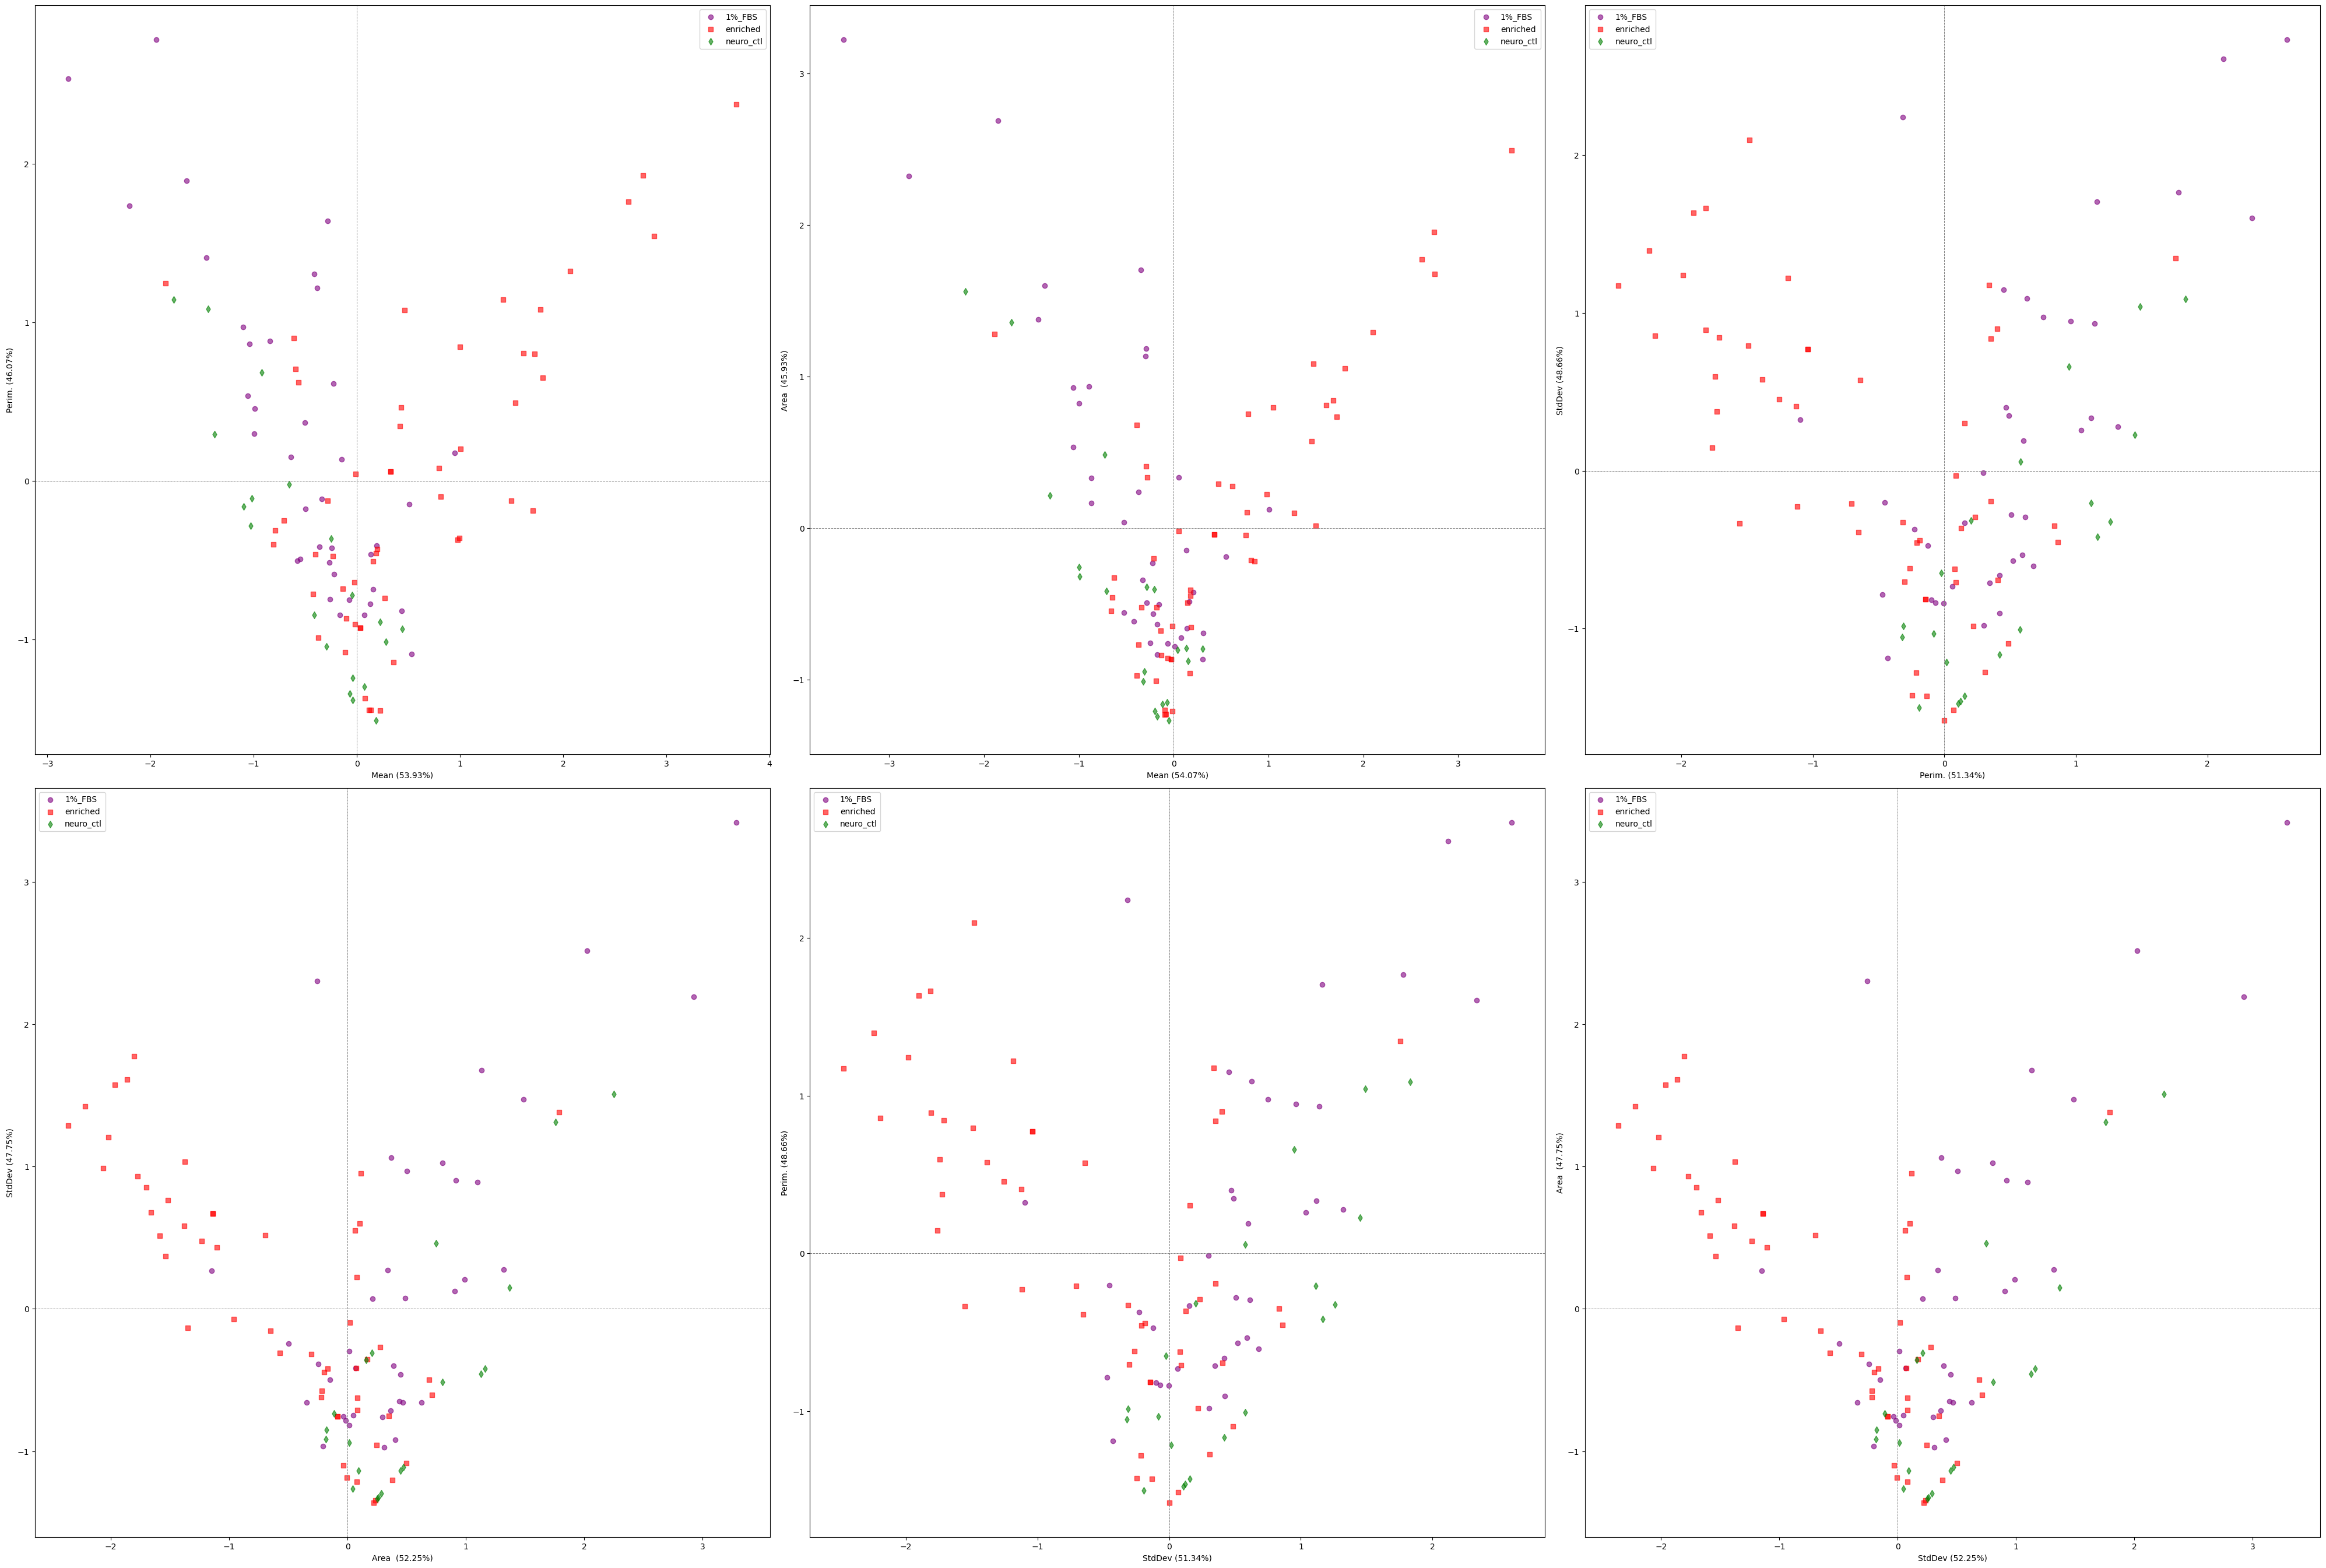

In [12]:
# Combinações de características com correlação próxima a zero
feature_combinations = [
('Mean', 'Perim.'),
('Mean', 'Area '),
('Perim.', 'StdDev'),
('Area ', 'StdDev'),
('StdDev', 'Perim.'),
('StdDev', 'Area ')
]
# Definir o tamanho da figura
plt.figure(figsize=(40, 40))

# Configurações para os gráficos
colors = ['purple', 'red', 'green', 'orange']  # Cores para os grupos
markers = ['o', 's', 'd', '^']  # Marcadores para os grupos

# Iterar sobre cada par de características na lista feature_combinations
for idx, (feature1, feature2) in enumerate(feature_combinations):
    # Selecionar as características relevantes
    X = data[[feature1, feature2]]
    
    # Normalizar os dados
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    # Aplicar o PCA
    pca = PCA(0.95)
    X_pca = pca.fit_transform(X_normalized)
    
    # Aplicar o agrupamento hierárquico
    Z = linkage(X_pca, method='ward')
    
    # Definir o número de clusters desejados
    num_clusters = 3
    
    # Realizar o clustering hierárquico e obter os rótulos dos clusters
    labels = fcluster(Z, num_clusters, criterion='maxclust')
    
    # Configurar o subplot
    plt.subplot(len(feature_combinations)//3 + 1, 3, idx+1)
    
    # Iterar sobre cada grupo
    for i, grupo in enumerate(data['Grupo'].unique()):
        indices = data[data['Grupo'] == grupo].index
        plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=grupo, color=colors[i], alpha=0.6, marker=markers[i])
    
    # Adicionar linhas de referência para os eixos
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
    
    # Adicionar nomes das características e variáveis nos eixos
    plt.xlabel(f"{X.columns[0]} ({pca.explained_variance_ratio_[0] * 100:.2f}%)")
    plt.ylabel(f"{X.columns[1]} ({pca.explained_variance_ratio_[1] * 100:.2f}%)")
    plt.legend()

# Salvar a figura
#plt.savefig('Subplots_fotoesfera.jpeg')

plt.tight_layout()
plt.show()

# Principal Component Analysis (nao funcionou)

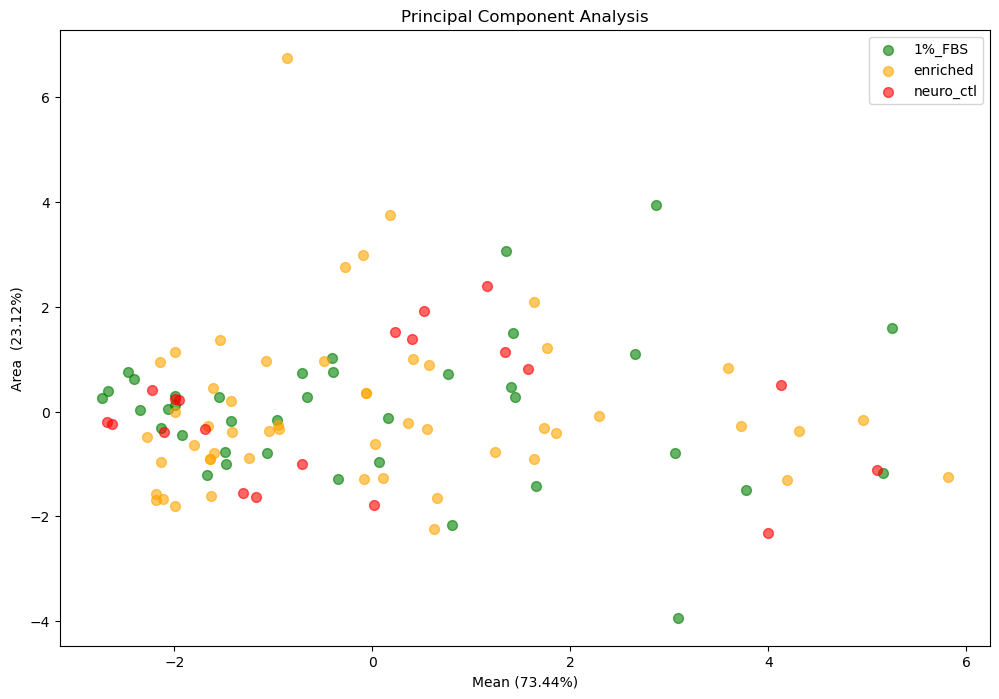

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd


# Dividir os dados em cinco grupos com base no tratamento
tratamentos = data['Grupo'].unique()

# Inicializar o gráfico
plt.figure(figsize=(12, 8))

# Loop através de cada tratamento
for tratamento in tratamentos:
    # Selecionar os dados para o tratamento atual
    dados_tratamento = data[data['Grupo'] == tratamento]
    
    # Selecionar as características relevantes para o tratamento atual
    X = dados_tratamento [['Mean','Area ','StdDev','Median','Mode','IntDen','Perim.']]
    
    # Normalizar os dados
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    # Aplicar o PCA
    pca = PCA(0.90)
    X_pca = pca.fit_transform(X_normalized)
    
    # Plotar os resultados do PCA para o tratamento atual
    if tratamento == 'neuro_ctl':
        plt.scatter(X_pca[:, 0], X_pca[:, 1], label='neuro_ctl', color='red', s=50, alpha=0.6)
    elif tratamento == '1%_FBS':
        plt.scatter(X_pca[:, 0], X_pca[:, 1], label='1%_FBS', color='green', s=50, alpha=0.6)
    elif tratamento == 'enriched':
        plt.scatter(X_pca[:, 0], X_pca[:, 1], label='enriched', color='orange', s=50, alpha=0.6)

# Adicionar legendas e título
plt.title('Principal Component Analysis')
# Adicionar nomes das características e variáveis nos eixos
plt.xlabel(f"{X.columns[0]} ({pca.explained_variance_ratio_[0] * 100:.2f}%)")
plt.ylabel(f"{X.columns[1]} ({pca.explained_variance_ratio_[1] * 100:.2f}%)")
plt.legend()

# Mostrar o gráfico
plt.show()
